# Lyft challenge 2018

Project plan:
    1. Build all the infrastructure code like read dataset, image annotation, F score, data augmentation, validation set
    2. Use FCN8 for the time being to see how good the model can go
    3. 

In [2]:
import os.path
import warnings
from distutils.version import LooseVersion
import sys
import numpy as np
import re
import random
from glob import glob
from tqdm import tqdm
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
import time
import cv2

In [ ]:
import tensorflow as tf

## Loading data set

The original dataset contains the class

| Value | Tag  | Color | Remarks|
|:-----| :-----|:-----|
| 0 | None | 0x000000 | |
| 1 | Buildings |  | |
| 2 | Fences | | |
| 3 | Other | | |
| 4 | Pedestrians | 215 19 52 | |
| 5 | Poles | 136 141 125 | |
| 6, 7 | RoadLines, Roads | Combine to 7, and use F0.5 | 117 55 116 | |
| 8 | Sidewalks | 240 31 227 | |
| 9 | Vegetation | 95 131 31 | |
| 10 | Vehicles | use F2 | 0 2 131 |
| 11 | Walls | | |
| 12 | TrafficSigns | | |

In [2]:
num_class = 13

In [3]:
def show_image(im, figsize=(8,8), ax=None, alpha=None):
    if not ax: fix, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

def show_categorization(im, figsize=(8,8), ax=None, alpha=None, title=None):
    if not ax: fix, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, cmap='nipy_spectral', alpha=alpha)
    ax.set_axis_off()
    if title is not None:
        ax.set_title(title)
    return ax

In [4]:
def preprocess_labels(label_image):
    # Identify lane marking pixels (label is 6)
    labels_new = np.copy(label_image)
    lane_marking_pixels = (label_image[:,:,0] == 6).nonzero()
    # Set lane marking pixels to road (label is 7)
    labels_new[lane_marking_pixels] = 7

    # Identify all vehicle pixels
    vehicle_pixels = (label_image[:,:,0] == 10).nonzero()
    # Isolate vehicle pixels associated with the hood (y-position > 496)
    hood_indices = (vehicle_pixels[0] >= 496).nonzero()[0]
    hood_pixels = (vehicle_pixels[0][hood_indices], \
                   vehicle_pixels[1][hood_indices])
    # Set hood pixel labels to 0
    labels_new[hood_pixels] = 0
    # Return the preprocessed label image 
    return labels_new


def gen_batch_function(data_folder, image_shape):
    """
    Generate function to create batches of training data
    :param data_folder: Path to folder that contains all the datasets
    :param image_shape: Tuple - Shape of image
    :return:
    """
    def get_batches_fn(batch_size):
        """
        Create batches of training data
        :param batch_size: Batch Size
        :return: Batches of training data
        """
        image_paths = glob(os.path.join(data_folder, 'CameraRGB', '*.png'))
        label_paths = {
            os.path.basename(path): path
            for path in glob(os.path.join(data_folder, 'CameraSeg', '*.png'))}

        random.shuffle(image_paths)
        for batch_i in range(0, len(image_paths), batch_size):
            images = []
            gt_images = []
            for image_file in image_paths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
                gt_image = scipy.misc.imresize(scipy.misc.imread(gt_image_file), image_shape)

                gt_bg = preprocess_labels(gt_image)[:,:,0:1]
                gt_image = None
                for i in range(13):
                    gt_temp = np.all(gt_bg == i, axis=2)
                    gt_temp = gt_temp.reshape(*gt_temp.shape, 1)
                    if gt_image is None:
                        gt_image = gt_temp
                    else:
                        gt_image = np.concatenate((gt_image, gt_temp), axis=2)

                images.append(image)
                gt_images.append(gt_image)

            yield np.array(images), np.array(gt_images)
    return get_batches_fn

/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


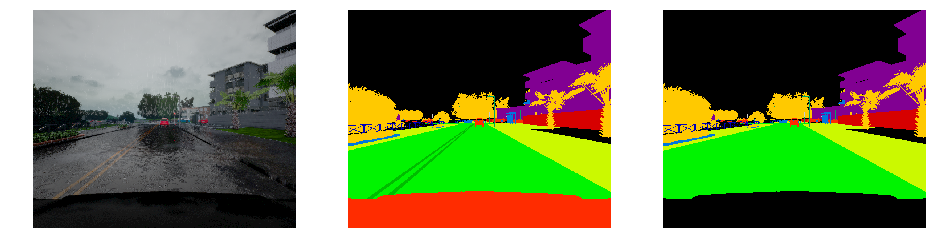

In [5]:
sample_image = scipy.misc.imread('./data/Train/CameraRGB/282.png')
sample_label = scipy.misc.imread('./data/Train/CameraSeg/282.png')
processed_label = preprocess_labels(sample_label)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16,4))
show_image(sample_image,ax=ax1)
show_categorization(sample_label[:,:,0], ax=ax2)
show_categorization(processed_label[:,:,0], ax=ax3)
plt.show()

/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


debug (1, 600, 800, 13)


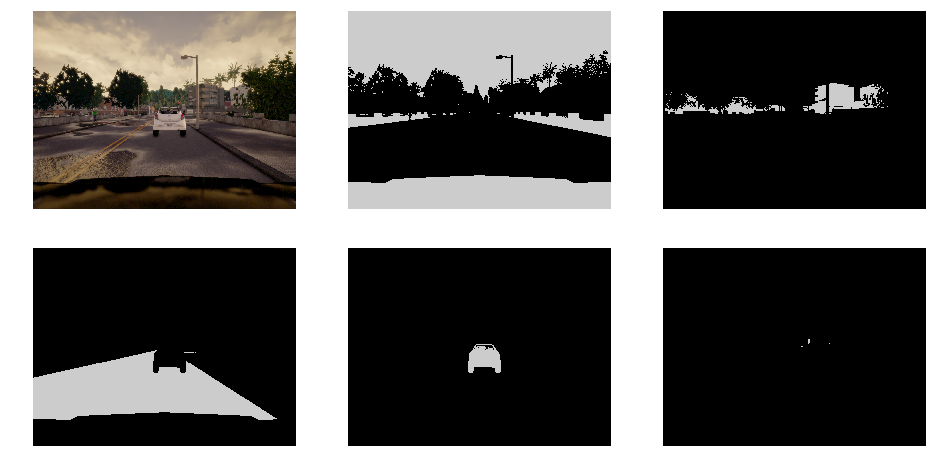

In [6]:
get_batches_fn = gen_batch_function('./data/Train', (600, 800))

for image, label in get_batches_fn(1):
    f, ax = plt.subplots(2, 3, sharey=True, figsize=(16,8))
    show_image(image[0],ax=ax[0][0])
    print('debug', label.shape)
    show_categorization(label[0][:,:,0].reshape(600, 800), ax=ax[0][1])
    show_categorization(label[0][:,:,1].reshape(600, 800), ax=ax[0][2])
    show_categorization(label[0][:,:,7].reshape(600, 800), ax=ax[1][0])
    show_categorization(label[0][:,:,10].reshape(600, 800), ax=ax[1][1])
    show_categorization(label[0][:,:,12].reshape(600, 800), ax=ax[1][2])
    plt.show()
    break

## Image augmentation

Apply the following image augmentation when training
1. Random shadow
2. Brightness augmentation
3. Translation

In [9]:
def apply_random_shadow(image):
    #
    # Add a random shadow to a BGR image to pretend
    # we've got clouds or other interference on the road.
    #
    rows, cols, _ = image.shape
    top_y = cols * np.random.uniform()
    top_x = 0
    bot_x = rows
    bot_y = cols * np.random.uniform()
    image_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    shadow_mask = 0 * image_hls[:, :, 1]
    X_m = np.mgrid[0:image.shape[0], 0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0], 0:image.shape[1]][1]
    shadow_mask[((X_m - top_x) * (bot_y - top_y) - (bot_x - top_x) * (Y_m - top_y) >= 0)] = 1

    if np.random.randint(2) == 1:
        random_bright = .5
        cond1 = (shadow_mask == 1)
        cond0 = (shadow_mask == 0)
        if np.random.randint(2) == 1:
            image_hls[:, :, 1][cond1] = image_hls[:, :, 1][cond1] * random_bright
        else:
            image_hls[:, :, 1][cond0] = image_hls[:, :, 1][cond0] * random_bright

    image = cv2.cvtColor(image_hls, cv2.COLOR_HLS2RGB)
    return image


def apply_brightness_augmentation(image):
    #
    # expects input image as BGR, adjusts brightness to
    # pretend we're in different lighting conditions.
    #
    image1 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    image1[:, :, 2] = image1[:, :, 2] * random_bright
    image2 = cv2.cvtColor(image1, cv2.COLOR_HSV2RGB)
    return image2


def apply_translation(image, label, translation_range):
    #
    # Shift image up or down a bit within trans_range pixels,
    # filling missing area with black.  IMG is in BGR format.
    #
    rows, cols, _ = image.shape
    tr_x = translation_range * np.random.uniform() - translation_range / 2
    tr_y = 10 * np.random.uniform() - 10 / 2
    trans_m = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    img_tr = cv2.warpAffine(image, trans_m, (cols, rows))
    label_tr = cv2.warpAffine(label, trans_m, (cols, rows))
    return img_tr, label_tr

/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


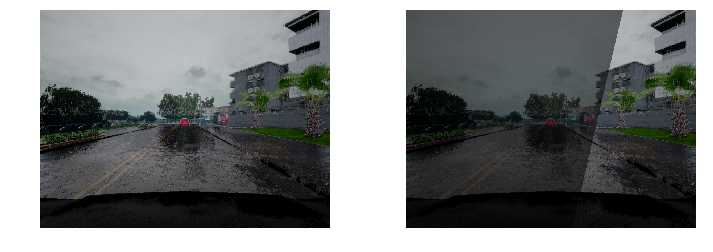

In [13]:
sample_image = scipy.misc.imread('./data/Train/CameraRGB/282.png')
output_image = apply_random_shadow(sample_image)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
show_image(sample_image,ax=ax1)
show_image(output_image,ax=ax2)

/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


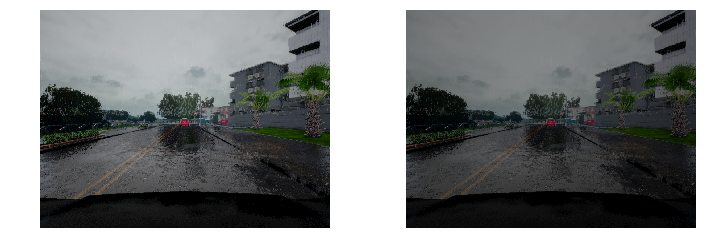

In [20]:
sample_image = scipy.misc.imread('./data/Train/CameraRGB/282.png')
output_image = apply_brightness_augmentation(sample_image)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
show_image(sample_image,ax=ax1)
show_image(output_image,ax=ax2)

/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


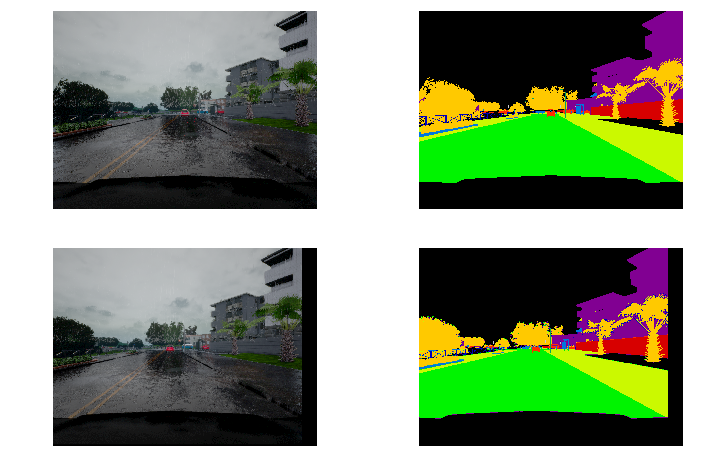

In [26]:
sample_image = scipy.misc.imread('./data/Train/CameraRGB/282.png')
sample_label = scipy.misc.imread('./data/Train/CameraSeg/282.png')
processed_label = preprocess_labels(sample_label)
output_image, output_label = apply_translation(sample_image, processed_label, 100)

f, ax = plt.subplots(2, 2, sharey=True, figsize=(12,8))
show_image(sample_image,ax=ax[0][0])
show_categorization(processed_label[:,:,0],ax=ax[0][1])
show_image(output_image,ax=ax[1][0])
show_categorization(output_label[:,:,0],ax=ax[1][1])

## Scoring and optimization function in NN

Scoring  final $\rm{F}$ score will be the average of your $\rm{F}_{0.5}$  score for road surface and your $\rm{F}_{2}$ score for vehicles.

$\beta(\rm{vehicle}) = 2$

$\beta(\rm{road}) = 0.5$

$\rm{F_{avg}} = \frac{\rm{F}_{0.5} + \rm{F}_{2}}{2}$


For the neural network, we still stick to cross entrophy to see the effect first, before consider asking neural network to optimize f-score directly

## Define the netework

The first network I will try is VGG16-FCN8

In [8]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    #   Use tf.saved_model.loader.load to load the model and weights
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    tf.saved_model.loader.load(
        sess,
        [vgg_tag],
        vgg_path)

    detection_graph = tf.get_default_graph()
    vgg_input_tensor = detection_graph.get_tensor_by_name(vgg_input_tensor_name)
    vgg_keep_prob_tensor = detection_graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    vgg_layer3_out_tensor = detection_graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    vgg_layer4_out_tensor = detection_graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    vgg_layer7_out_tensor = detection_graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    return vgg_input_tensor, vgg_keep_prob_tensor, vgg_layer3_out_tensor, vgg_layer4_out_tensor, vgg_layer7_out_tensor

def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """

    fcn_layer7_conv_1x1 = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, padding='SAME',
                                kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3), name='fcn_layer7_conv_1x1')

    fcn_layer7_deconv = tf.layers.conv2d_transpose(fcn_layer7_conv_1x1, num_classes, 4, 2, padding='SAME',
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3), name='fcn_layer7_deconv')

    vgg_layer4_out_scale = tf.multiply(vgg_layer4_out, 0.01, name='vgg_layer4_out_scale')

    fcn_layer4_conv_1x1 = tf.layers.conv2d(vgg_layer4_out_scale, num_classes, 1, padding='SAME',
                                           kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                           kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3), name='fcn_layer4_conv_1x1')

    intermediate_1 = tf.add(fcn_layer7_deconv, fcn_layer4_conv_1x1, name='intermediate_1')

    vgg_layer3_out_scale = tf.multiply(vgg_layer3_out, 0.0001, name='vgg_layer3_out_scale')

    fcn_layer3_conv_1x1 = tf.layers.conv2d(vgg_layer3_out_scale, num_classes, 1, padding='SAME',
                                           kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                           kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3), name='fcn_layer3_conv_1x1')

    intermediate_1_deconv = tf.layers.conv2d_transpose(intermediate_1, num_classes, 4, 2, padding='SAME',
                                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                                    kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3), name='intermediate_1_deconv')

    intermediate_2 = tf.add(intermediate_1_deconv, fcn_layer3_conv_1x1, name='intermediate_2')

    fcn_output = tf.layers.conv2d_transpose(intermediate_2, num_classes, 16, 8, padding='SAME',
                                            kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                            kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3), name='fcn_output')

    return fcn_output

def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """

    # freeze all convolution variables
    tvars = tf.trainable_variables()
    trainable_vars = [var for var in tvars if not(var.name.startswith('conv'))]

    #print("Trainable parameters are: ")
    #for var in trainable_vars:
    #    print(var.name + "\n")

    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    correct_label = tf.reshape(correct_label, (-1, num_classes))
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=correct_label))

    tf.summary.scalar('cross_entropy_loss', cross_entropy_loss)
    # add regularization to the loss
    reg_losses = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    tf.summary.scalar('regularization loss', reg_losses)
    reg_constant = 0.01
    loss = cross_entropy_loss + reg_constant * reg_losses

    tf.summary.scalar('total loss', loss)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_operation = optimizer.minimize(cross_entropy_loss, var_list=trainable_vars)

    return logits, training_operation, loss

def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate, writer=None, merged=None, logits=None):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    :param writer: Tensorboard writer
    :param merged: Tensorboard merged summary
    """
    sess.run(tf.global_variables_initializer())

    keep_prob_value = 0.5
    learning_rate_value = 0.001

    show_image = False

    step = 0
    for i in range(epochs):
        print("Epoch: = {:d}".format(i))
        for image, label in get_batches_fn(batch_size):
            _, loss = sess.run([train_op, cross_entropy_loss],
                               feed_dict={input_image: image, correct_label: label, keep_prob: keep_prob_value, learning_rate: learning_rate_value})

            if step % 5 == 0 and writer is not None and merged is not None:
                summary = sess.run(merged, feed_dict={input_image: image, correct_label: label, keep_prob: 1, learning_rate: learning_rate_value})
                writer.add_summary(summary, step)

            step = step+1

        if writer is not None and logits is not None:
            gather_training_stats(sess, i, get_batches_fn, logits, keep_prob, input_image, writer)

def mean_iou_score(y_pred, y_true):
    class_iou_list = []
    labels = set(y_true).union(set(y_pred))
    for i in labels:
        intersect = np.sum(np.logical_and((y_pred == i), (y_true == i)))
        union = np.sum(np.logical_or((y_pred == i), (y_true == i)))
        class_iou_list.append(intersect * 1. / union)

    return np.mean(class_iou_list)

def mean_iou(label, prediction):
    iou_list = []
    for i in range(len(label)):
        score = mean_iou_score(label[i], prediction[i])
        iou_list.append(score)

    return np.mean(iou_list)

def accuracy_score(y_true, y_pred):
    p = np.sum(y_true == y_pred)
    return p * 1.0 / len(y_true)

def accuracy(label, prediction):
    accuracy_list = []
    for i in range(len(label)):
        score = accuracy_score(label[i], prediction[i])
        accuracy_list.append(score)

    return np.mean(accuracy_list)

def f1_score(y_true, y_pred):
    tp = np.sum(np.logical_and(y_true, y_pred))
    #tn = np.sum(np.logical_and(y_true == False, y_pred=False))
    fp = np.sum(np.logical_and(np.logical_not(y_true), y_pred))
    fn = np.sum(np.logical_and(y_true, np.logical_not(y_pred)))

    if tp + fp != 0:
        p = (1. * tp) / (tp + fp)
    else:
        p = 1

    if tp + fn != 0:
        r = (1. * tp) / (tp + fn)
    else:
        r =0

    if p + r > 0:
        f = 2 * p * r / (p + r)
    else:
        f = 0

    return f

def fscore(label, prediction):
    fscore_list = []
    for i in range(len(label)):
        score = f1_score(label[i], prediction[i])
        fscore_list.append(score)

    return np.mean(fscore_list)

def gather_training_stats(sess, epoch, get_batches_fn, logits, keep_prob, input_image, writer):
    # run all the batch again
    batch_size = 32
    prediction_list = []
    label_list = []
    for image, label in get_batches_fn(batch_size):
        curr_batch_size = len(label)
        image_shape = (len(label[0]), len(label[0][0]))
        softmax = sess.run([tf.nn.softmax(logits)],
                               {keep_prob: 1.0, input_image: image})
        softmax = np.argmax(np.array(softmax), axis=2)
        softmax = np.reshape(softmax, (curr_batch_size, image_shape[0] * image_shape[1]))
        label = np.argmax(np.array(label), axis=3)
        label = np.reshape(label, (curr_batch_size, image_shape[0] * image_shape[1]))

        for i in range(curr_batch_size):
            prediction_list.append(softmax[i])
            label_list.append(label[i])

    mean_iou_r = mean_iou(label_list, prediction_list)
    accuracy_r = accuracy(label_list, prediction_list)
    fscore_r = fscore(label_list, prediction_list)

    summary = tf.Summary()
    summary.value.add(tag="training_accuracy", simple_value=accuracy_r)
    summary.value.add(tag="training_iou", simple_value=mean_iou_r)
    summary.value.add(tag="training_fscore", simple_value=fscore_r)
    writer.add_summary(summary, epoch)

In [9]:
def train():
    num_classes = 13
    image_shape = (288, 384)
    data_dir = './data'
    epochs = 10
    batch_size = 16
    
    LOGDIR = os.path.join('.\\log', 'fcn8_log')

    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = gen_batch_function(os.path.join(data_dir, 'Train'), image_shape)

        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

        # Build NN using load_vgg, layers, and optimize function
        input_image, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(sess, vgg_path)
        layer_output = layers(layer3_out, layer4_out, layer7_out, num_classes)

        correct_label = tf.placeholder(tf.int32, (None, image_shape[0], image_shape[1], num_classes), name='correct_label')
        learning_rate = tf.placeholder(tf.float32, name='learning_rate')

        logits, train_op, cross_entropy_loss = optimize(layer_output, correct_label, learning_rate, num_classes)

        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(LOGDIR, graph=sess.graph)

        # Train NN using the train_nn function
        train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate, train_writer, merged, logits=logits)

        # Save the model for future use
        saver = tf.train.Saver()
        save_path = saver.save(sess, ".\\fcn8\\model.ckpt")
        print("Model saved in path: %s" % save_path)

tf.reset_default_graph()
train()

INFO:tensorflow:Restoring parameters from b'./data\\vgg\\variables\\variables'
INFO:tensorflow:Summary name regularization loss is illegal; using regularization_loss instead.
INFO:tensorflow:Summary name total loss is illegal; using total_loss instead.
Epoch: = 0


C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


ResourceExhaustedError: OOM when allocating tensor with shape[8,64,608,800] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv1_2/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1_1/Relu, conv1_2/filter/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: gradients/intermediate_2_grad/Shape/_271 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_444_gradients/intermediate_2_grad/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv1_2/Conv2D', defined at:
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\asyncio\base_events.py", line 345, in run_forever
    self._run_once()
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\asyncio\base_events.py", line 1312, in _run_once
    handle._run()
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\asyncio\events.py", line 125, in _run
    self._callback(*self._args)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-b2511cd23de3>", line 41, in <module>
    train()
  File "<ipython-input-9-b2511cd23de3>", line 20, in train
    input_image, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(sess, vgg_path)
  File "<ipython-input-7-bfca436f91c5>", line 19, in load_vgg
    vgg_path)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\saved_model\loader_impl.py", line 219, in load
    saver = tf_saver.import_meta_graph(meta_graph_def_to_load, **saver_kwargs)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\training\saver.py", line 1955, in import_meta_graph
    **kwargs)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\meta_graph.py", line 743, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\util\deprecation.py", line 432, in new_func
    return func(*args, **kwargs)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\importer.py", line 513, in import_graph_def
    _ProcessNewOps(graph)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\importer.py", line 303, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\ops.py", line 3540, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\ops.py", line 3540, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\ops.py", line 3428, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[8,64,608,800] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv1_2/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1_1/Relu, conv1_2/filter/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: gradients/intermediate_2_grad/Shape/_271 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_444_gradients/intermediate_2_grad/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



## Show the result

In [11]:
def resize_softmax(softmax, image_shape):
    num_class =  softmax.shape[2]
    result = None
    for i in range(num_class):
        img_layer = scipy.misc.imresize(softmax[:,:,i], image_shape, interp='cubic').reshape(image_shape[0], image_shape[1], 1)
        
        if result is None:
            result = img_layer
        else:
            result = np.concatenate((result, img_layer), axis=2)
            
    return result

## Show that the function works
def gen_test_output(sess, logits, keep_prob, image_pl, data_folder, image_shape):
    """
    Generate test output using the test images
    :param sess: TF session
    :param logits: TF Tensor for the logits
    :param keep_prob: TF Placeholder for the dropout keep robability
    :param image_pl: TF Placeholder for the image placeholder
    :param data_folder: Path to the folder that contains the datasets
    :param image_shape: Tuple - Shape of image
    :return: Output for for each test image
    """
    
    for image_file in glob(os.path.join(data_folder, 'CameraRGB', '*.png')):
        img = scipy.misc.imread(image_file)
        original_image_shape = (img.shape[0], img.shape[1])
        image = scipy.misc.imresize(img, image_shape)

        im_softmax = sess.run(
            [tf.nn.softmax(logits)],
            {keep_prob: 1.0, image_pl: [image]})
        num_classes = im_softmax[0].shape[1]
        im_softmax = im_softmax[0].reshape(image_shape[0], image_shape[1], num_classes)
        #resize introduce more error.
        #im_softmax_org_size = resize_softmax(im_softmax, original_image_shape)
        im_argmax = np.argsort(im_softmax, axis=2)[:,:,num_classes-1].reshape(image_shape[0], image_shape[1], 1)
        
        im_blue = np.zeros((image_shape[0], image_shape[1], 1))
        im_green = np.zeros((image_shape[0], image_shape[1], 1))
        
        final_im = np.concatenate((im_argmax, im_blue, im_green), axis=2)

        yield os.path.basename(image_file), np.array(final_im)

def save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image):
    # Make folder for current run
    output_dir = os.path.join(runs_dir, str(time.time()))
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    # Run NN on test images and save them to HD
    print('Training Finished. Saving test images to: {}'.format(output_dir))
    image_outputs = gen_test_output(
        sess, logits, keep_prob, input_image, os.path.join(data_dir, 'Test'), image_shape)
    for name, image in image_outputs:
        #scipy.misc.imsave(os.path.join(output_dir, name), image)
        scipy.misc.toimage(image, cmin=0, cmax=255).save(os.path.join(output_dir, name))

def run_test():
    runs_dir = './runs'
    data_dir = './data'
    image_shape = (288, 384)
    num_classes = 13
    
    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')

        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

        # Build NN using load_vgg, layers, and optimize function
        input_image, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(sess, vgg_path)
        layer_output = layers(layer3_out, layer4_out, layer7_out, num_classes)

        correct_label = tf.placeholder(tf.int32, (None, image_shape[0], image_shape[1], num_classes), name='correct_label')
        learning_rate = tf.placeholder(tf.float32, name='learning_rate')

        logits, train_op, cross_entropy_loss = optimize(layer_output, correct_label, learning_rate, num_classes)

        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint("./fcn8"))
            
        save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)
        
tf.reset_default_graph()
run_test()

INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
INFO:tensorflow:Summary name regularization loss is illegal; using regularization_loss instead.
INFO:tensorflow:Summary name total loss is illegal; using total_loss instead.
INFO:tensorflow:Restoring parameters from ./fcn8/model.ckpt
Training Finished. Saving test images to: ./runs/1527426414.6626115


/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:61: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.

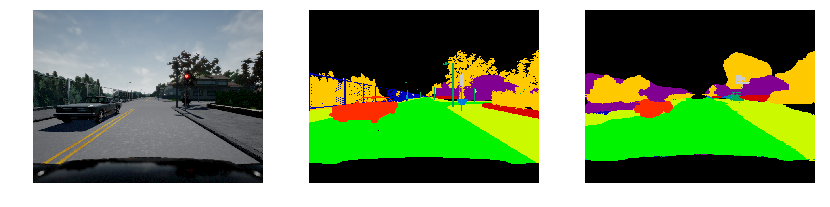

In [10]:
sample_image = scipy.misc.imread('../data/Test/CameraRGB/000109.png')
sample_label = scipy.misc.imread('../data/Test/CameraSeg/000109.png')
processed_label = preprocess_labels(sample_label)
result_min = scipy.misc.imread('./runs/1527607089.6424484/000109.png')
result = scipy.misc.imresize(result_min, (600,800), interp='nearest')

f, ax = plt.subplots(1, 3, sharey=False, figsize=(14,10))
show_image(sample_image,ax=ax[0])
show_categorization(processed_label[:,:,0], ax=ax[1])
show_categorization(result[:,:,0], ax=ax[2])
plt.show()

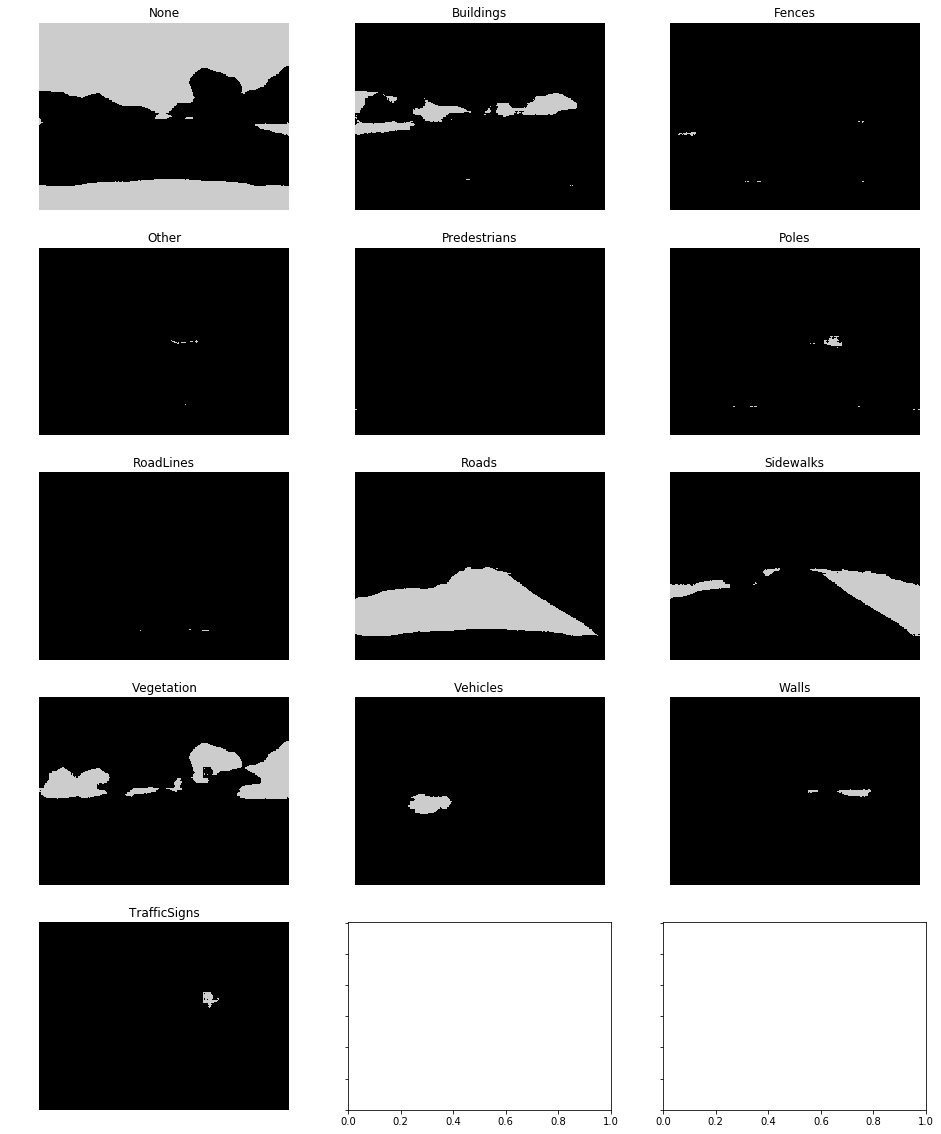

In [13]:
f, ax = plt.subplots(5, 3, sharey=True, figsize=(16,20))
show_categorization((result_min[:,:,0]==0).reshape(600,800), ax=ax[0][0], title="None")
show_categorization((result_min[:,:,0]==1).reshape(600,800), ax=ax[0][1], title="Buildings")
show_categorization((result_min[:,:,0]==2).reshape(600,800), ax=ax[0][2], title="Fences")
show_categorization((result_min[:,:,0]==3).reshape(600,800), ax=ax[1][0], title="Other")
show_categorization((result_min[:,:,0]==4).reshape(600,800), ax=ax[1][1], title="Predestrians")
show_categorization((result_min[:,:,0]==5).reshape(600,800), ax=ax[1][2], title="Poles")
show_categorization((result_min[:,:,0]==6).reshape(600,800), ax=ax[2][0], title="RoadLines")
show_categorization((result_min[:,:,0]==7).reshape(600,800), ax=ax[2][1], title="Roads")
show_categorization((result_min[:,:,0]==8).reshape(600,800), ax=ax[2][2], title="Sidewalks")
show_categorization((result_min[:,:,0]==9).reshape(600,800), ax=ax[3][0], title="Vegetation")
show_categorization((result_min[:,:,0]==10).reshape(600,800), ax=ax[3][1], title="Vehicles")
show_categorization((result_min[:,:,0]==11).reshape(600,800), ax=ax[3][2], title="Walls")
show_categorization((result_min[:,:,0]==12).reshape(600,800), ax=ax[4][0], title="TrafficSigns")
plt.show()

## Scoring and optimization function in NN

Scoring  final $\rm{F}$ score will be the average of your $\rm{F}_{0.5}$  score for road surface and your $\rm{F}_{2}$ score for vehicles.

$\beta(\rm{vehicle}) = 2$

$\beta(\rm{road}) = 0.5$

$\rm{F_{avg}} = \frac{\rm{F}_{0.5} + \rm{F}_{2}}{2}$


###  F1 score of each classes

We will use the 000082.png as an example

In [14]:
object_list = ["None", "Buildings", "Fences", "Other", "Predestrians", "Poles", "RoadLines", "Roads", "Sidewalks", "Vegetation", "Vehicles", "Walls", "TrafficSigns"]
sample_label = scipy.misc.imread('./data/Test/CameraSeg/000109.png')
#y_true = preprocess_labels(sample_label)[:,:,0].ravel()
y_true = sample_label[:,:,0].ravel()
y_pred = scipy.misc.imread('./runs/1527607089.6424484/000109.png')[:,:,0]
y_pred_up = scipy.misc.imresize(y_pred, (600,800), interp='nearest').ravel()

import sklearn.metrics

for idx, obj_name in enumerate(object_list):
    y_class_true = (y_true ==idx)
    y_class_pred = (y_pred_up ==idx)
    score = sklearn.metrics.f1_score(y_class_true, y_class_pred)
    print("F-score of %s: %.3f" %(obj_name, score))


/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


F-score of None: 0.809
F-score of Buildings: 0.490
F-score of Fences: 0.000
F-score of Other: 0.012
F-score of Predestrians: 0.000
F-score of Poles: 0.142
F-score of RoadLines: 0.005
F-score of Roads: 0.917
F-score of Sidewalks: 0.800
F-score of Vegetation: 0.775
F-score of Vehicles: 0.135
F-score of Walls: 0.061
F-score of TrafficSigns: 0.483


### submission score

In [15]:
sample_label = scipy.misc.imread('./data/Test/CameraSeg/000109.png')
#y_true = preprocess_labels(sample_label)[:,:,0].ravel()
y_true = sample_label[:,:,0].ravel()
y_pred = scipy.misc.imread('./runs/1527308988.3124208/000109.png')[:,:,0]
y_pred_up = scipy.misc.imresize(y_pred, (600,800), interp='nearest').ravel()

y_road_true = (y_true == 7)
y_road_pred = (y_pred_up == 7)
y_vehicle_true = (y_true == 10)
y_vehicle_pred = (y_pred_up == 10)

vehicle_score = sklearn.metrics.fbeta_score(y_vehicle_true, y_vehicle_pred, 2)
roadscore = sklearn.metrics.fbeta_score(y_road_true, y_road_pred, 0.5)
score = (vehicle_score + roadscore) /2
print("Vehicle score = %.3f" % vehicle_score)
print("Road score = %.3f" % roadscore)
print("Submission score = %.3f" % score)

Vehicle score = 0.892
Road score = 0.898
Submission score = 0.895


/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [16]:
dir_true_label = "./data/Test/CameraSeg/"
dir_pred_label = "./runs/1527308988.3124208"

vehicle_score_list = []
road_score_list = []
score_list = []

for label_file in glob(os.path.join(dir_true_label, '*.png')):
    
    base_file_name = os.path.basename(label_file)
    true_label_fn = os.path.join(dir_true_label, base_file_name)
    pred_label_fn = os.path.join(dir_pred_label, base_file_name)
    
    sample_label = scipy.misc.imread(true_label_fn)
    #y_true = preprocess_labels(sample_label)[:,:,0].ravel()
    y_true = sample_label[:,:,0].ravel()
    y_pred = scipy.misc.imread(pred_label_fn)[:,:,0]
    y_pred_up = scipy.misc.imresize(y_pred, (600,800), interp='nearest').ravel()

    y_road_true = (y_true == 7)
    y_road_pred = (y_pred_up == 7)
    y_vehicle_true = (y_true == 10)
    y_vehicle_pred = (y_pred_up == 10)

    vehicle_score = sklearn.metrics.fbeta_score(y_vehicle_true, y_vehicle_pred, 2)
    road_score = sklearn.metrics.fbeta_score(y_road_true, y_road_pred, 0.5)
    score = (vehicle_score + roadscore) /2
    
    vehicle_score_list.append(vehicle_score)
    road_score_list.append(road_score)
    score_list.append(score)

print("Vehicle score = %.3f, std=%.3f" % (np.mean(vehicle_score_list), np.std(vehicle_score_list)))
print("Road score = %.3f, std=%.3f" % (np.mean(road_score_list), np.std(road_score_list)))
print("Submission score = %.3f, std=%.3f" % (np.mean(score_list), np.std(score_list)))

/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Vehicle score = 0.969, std=0.014
Road score = 0.926, std=0.020
Submission score = 0.934, std=0.007


## Submit the model

## Testing ground

In [28]:
from sklearn.metrics import jaccard_similarity_score
y_pred = [0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 2, 1, 3, 3 ,0 ,3]
y_true = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3 ,3 ,3]
jaccard_similarity_score(y_true, y_pred)

0.6875